<a href="https://colab.research.google.com/github/yuvalofek/FrequentistML/blob/master/FreqML1_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Frequentist ML Assignment 1 - Linear Regression**
Yuval Epstain Ofek
---

Note: I have been trying to teach myself python, so I would love comments and tips 

---



# **The provided Prompt:**

Download the prostate cancer dataset from the books resources:

https://web.stanford.edu/~hastie/ElemStatLearn/data.html

Replicate the analysis from chapter 3 of this dataset. Divide your data into roughly 80% train, 10% validation, 10% test. You must keep this split for all 3 parts of this assignment in order to compare the methods fairly. Replicate the textbooks analysis of this dataset. by doing the following

**a)** Plain old linear regression, with no regularization. You must code this one by hand (i.e use equation 3.6 to find the betas).  Report the mean squared error on the test dataset. Replicate tables 3.1 and 3.2. You will not need the validation set for this part of the assigment.

**b)** Ridge regression. You must also code this one by hand(eq 3.44 to find the betas). Select the optimal value of Lambda by cross-validation using the validation dataset. Report the mean squared error on the test dataset, using the best lambda you found on the validation set. DO NOT USE THE TEST DATASET TO CHOOSE LAMBDA. Plot a ridge plot similar to figure 3.8, but you can just sweep the lambda parameter (you don't have to scale it to degrees of freedom).

**c)** Lasso regression: Use  the built in packages in sci-kit learn or MATLAB to do a Lasso regression. Select the optimal value of lambda as in part b) and also display a Lasso plot similar to figure 3.10, but again you can just sweep the lambda parameter. 

Next, download a dataset suitable for linear regression from UCI or another repository. For now, this should be a dataset that only has numerical features, with no missing values. Repeat the analysis above on this dataset.

Which features did the Lasso select for you to include in your model? Do these features make sense?
Compute the MSE on the training dataset and the test dataset for all methods and comment on the results.  Compare this MSE to a baseline MSE.

**Stretch goal** (2 points): Add nonlinear and interaction terms to your dataset and try to improve the performance. Are you able to do so? 



#Imports

In [26]:
#Install Pandas profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

#import stuff
from sklearn import linear_model as lm  #linear model for Lasso
from sklearn.model_selection import train_test_split  #for spliting data
import matplotlib.pyplot as plt #plotting
import numpy as np  #lin alg 
import pandas as pd #data extraction from website

from pandas_profiling import ProfileReport  #profiling function
from tabulate import tabulate   #tables

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0rc1-py2.py3-none-any.whl size=258106 sha256=65ecdd866be67af17fe915eb909f43c72eba9bbb17be67ed354961ff268a10b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-cx4jgxxq/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling


#Prostate Data

## Importing the Prostate Data 

In [27]:
#import prostate.data
!wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data

#looking at prostate.data to verify formatting
!cat prostate.data | head -5

--2020-09-03 04:37:44--  https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7130 (7.0K)
Saving to: ‘prostate.data.12’

prostate.data.12    100%[===================>]   6.96K  --.-KB/s    in 0s      

2020-09-03 04:37:44 (256 MB/s) - ‘prostate.data.12’ saved [7130/7130]

	lcavol	lweight	age	lbph	svi	lcp	gleason	pgg45	lpsa	train
1	-0.579818495	2.769459	50	-1.38629436	0	-1.38629436	6	  0	-0.4307829	T
2	-0.994252273	3.319626	58	-1.38629436	0	-1.38629436	6	  0	-0.1625189	T
3	-0.510825624	2.691243	74	-1.38629436	0	-1.38629436	7	 20	-0.1625189	T
4	-1.203972804	3.282789	58	-1.38629436	0	-1.38629436	6	  0	-0.1625189	T


In [28]:
#reading the data into a numpy array of floats
df_prostate = pd.read_csv('prostate.data',
                 delimiter='\t',
                 index_col = 0,
                 usecols=list(np.arange(0,10)))
#df_prostate.insert(8, 'intercept', 1)
prostate_data = df_prostate.to_numpy().astype('float')
df_prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


##Splitting data into training, validation and testing

###Parameters

In [29]:
#data splitting conditions
PERCENT_VAL = 0.10
PERCENT_TEST = 0.10
random_state = 16  #for reproducibility

I felt like we would be splitting the data into 3 quite often, and decided to make a function to handle that (current functions I saw only handled train-test splits). 

*Note:* This is done a bit naively to match a very specific use case.

In [30]:
def train_val_test_split(X,y, test_size, val_size, random_state = None):
  '''Simplistically extended train_test_split to also provide a validation set'''

  #We want to split the data in 3, but the train_test_split only splits in 2. 
  #This means we need to split once to get a testing set and an intermediate set 
  #which we split again to get the validation and training sets. because 
  #train_test_split takes a percentage to determine the split, we first determine 
  #the relative percentage of the intermediate set needed to generate the 
  #necessary number of samples in the validation set:
  rel_val_percent = np.round((val_size)/(1-test_size), 2)

  #splitting the data
  X_inter, X_test, y_inter, y_test = train_test_split(X,
                                                      y,
                                                      test_size = test_size,
                                                      random_state = random_state
                                                      )
  X_train, X_val, y_train, y_val = train_test_split(X_inter,
                                                      y_inter,
                                                      test_size = rel_val_percent,
                                                      random_state = random_state
                                                      )
  
  return X_train, X_val, X_test, y_train, y_val, y_test

In [31]:


split_data = train_val_test_split(prostate_data[:,:-1],
                                  prostate_data[:,-1],
                                  PERCENT_TEST,
                                  PERCENT_VAL,
                                  random_state)
#unpacking
X_train, X_val, X_test, y_train, y_val, y_test = split_data

print('Input length:', len(prostate_data))
print('Number of training samples:', len(X_train))
print('Number of validation samples:', len(X_val))
print('Number of testing samples:', len(X_test))

Input length: 97
Number of training samples: 77
Number of validation samples: 10
Number of testing samples: 10


##Data Overview

I found that the easiest start is to use pandas profiling, so I generate a profile for the input:

In [32]:
#Getting a prodile of the dataset
#prostate_profile = ProfileReport(df_prostate, title="Pandas Profiling Report")
#prostate_profile

### Prostate Profile Comments:
The profile shows that there are no missing values. Given the size and nature of the data, I feel like there is no need for any changes so I proceed to the following steps. 

*Note:*
One part to note specifically is the correlations panel. This can give us a hint at how coefficients will relate to each other.

##Models

### Linear Regression

Here I create a class to handle linear regression with the following methods:

*   fit: takes X and y inputs and generates a weight vector using equation 3.6 for linear regression. 
*   predict: takes an X input and uses the weights previously fitted to generate a y^ prediction. 

I also made a function to calculate the mean squared error. 



In [33]:
# A class to handle the common uses of linear regression
class LinModel:
  def __init__(self):
    self.beta = None

  def fit(self, x,y):
    '''Linearly fit X data to y output'''
    #implementing eq 3.6
    X = np.concatenate((np.ones((x.shape[0], 1)),x), axis = 1)
    self.beta = np.linalg.solve((X.T @ X),X.T@y)
    return self.beta

  def predict(self,x):
    ''' Using stored coefficients, predict output based on data x'''
    X = np.concatenate((np.ones((x.shape[0], 1)),x), axis = 1)
    return X@self.beta

#function to calculate Mean square error
def mean_square_error(y, y_hat):
  ''' Calculate mean square error'''
  return np.mean((y-y_hat)**2)

Generating and fitting model

In [34]:
linmodel = LinModel()
beta_lin = linmodel.fit(X_train,y_train)

Test set MSE

In [35]:
testMSE_lin = mean_square_error(y_test, linmodel.predict(X_test))
print("Test MSE:", testMSE_lin)

Test MSE: 0.32141834766903077


####Recreating Table 3.1:
Correlation Table

In [36]:
def format_corr_table(corr_mat, coeff_names):
  '''Function to format the data into a correlation table'''

  corr_table = []
  #generate a list of lists, where the inner lists are rows
  for row_num in range(corr_mat.shape[0]):
    #get corr coefficients for the row
    vals = list(corr_mat[row_num, :])
    #make into strings
    vals = [str(round(val,3)) for val in vals]
    #prepend the coefficient name
    vals.insert(0,coeff_names[row_num])
    #remove redundant values
    vals = vals [:row_num+1]
    #uppend to table_mat
    corr_table.append(vals)

  return corr_table

In [37]:
#Calculate the correlation coefficients
corr_mat = np.corrcoef(X_train.T)
#formatting the correlation table 
coeff_names = list(df_prostate.columns.values[:-1])
corr_table = format_corr_table(corr_mat, coeff_names)

#Fixing title
coeff_names.insert(0,'Coefficients')

#generate and pring correlation table
corr = tabulate(corr_table[1:], headers = (coeff_names), tablefmt='pretty')
print('     Table 1: Correlations of predictors in the prostate cancer data.')
print(corr)

     Table 1: Correlations of predictors in the prostate cancer data.
+--------------+--------+---------+-------+-------+-------+-------+---------+
| Coefficients | lcavol | lweight |  age  | lbph  |  svi  |  lcp  | gleason |
+--------------+--------+---------+-------+-------+-------+-------+---------+
|   lweight    | 0.251  |         |       |       |       |       |         |
|     age      | 0.288  |  0.403  |       |       |       |       |         |
|     lbph     | 0.058  |  0.46   | 0.345 |       |       |       |         |
|     svi      | 0.519  |  0.123  |  0.2  | 0.034 |       |       |         |
|     lcp      | 0.662  |  0.123  | 0.189 | 0.094 | 0.64  |       |         |
|   gleason    | 0.462  |  0.094  | 0.366 | 0.177 | 0.377 | 0.542 |         |
|    pgg45     | 0.431  |  0.116  | 0.362 | 0.177 | 0.469 | 0.609 |  0.733  |
+--------------+--------+---------+-------+-------+-------+-------+---------+


####Recreating Table 3.2:
Linear model fit summary table

In [38]:
def format_summary_table(term, beta, s_e, z_scr, round_decimal = 2):
  '''Function to format the data into a summary table'''
  summary_mat = []
  #generate a list of lists, where the inner lists are rows
  for coeff_num in range(len(term)):
    row = list([term[coeff_num],
              round(beta[coeff_num],round_decimal),
              round(s_e[coeff_num],round_decimal),
              round(z_scr[coeff_num],round_decimal)])
    summary_mat.append(row)

  return summary_mat

In [39]:
def z_scorer(model, X, y, p, mse =mean_square_error):
  N = len(X_train)
  #implement equation 3.12 to get the z score, using 3.8b to get the stdv
  sigma =  np.sqrt(mean_square_error(y, model.predict(X))*N/(N-p-1))
  X = np.concatenate((np.ones((X.shape[0], 1)),X), axis = 1)
  sqrt_v = np.sqrt(np.diagonal(np.linalg.inv(np.matmul(X.T, X))))
  standard_error = sigma*sqrt_v
  z_score = model.beta/standard_error

  return standard_error,z_score

In [40]:
#the value of the variance approximation is VERY close to the MSE, but with a
# different dividing factor (MSE is N while here it is N-p-1)
p = len(coeff_names)-1

standard_error, Z_score = z_scorer(linmodel, X_train, y_train, p)

term = coeff_names[1:]
term.insert(0, 'intercept')
summary_mat = format_summary_table(term, beta_lin, standard_error, Z_score)

summary_header = ['Term', 'Coefficeint', 'Std. Error', 'Z Score']
summary = tabulate(summary_mat, headers = summary_header, tablefmt='pretty')
print('Table 2: Linear model fit to the prostate cancer data.')
print(summary)

Table 2: Linear model fit to the prostate cancer data.
+-----------+-------------+------------+---------+
|   Term    | Coefficeint | Std. Error | Z Score |
+-----------+-------------+------------+---------+
| intercept |    0.14     |    1.62    |  0.09   |
|  lcavol   |    0.57     |    0.11    |  5.42   |
|  lweight  |    0.67     |    0.25    |  2.63   |
|    age    |    -0.02    |    0.01    |  -1.7   |
|   lbph    |     0.1     |    0.07    |  1.44   |
|    svi    |    0.83     |    0.28    |  3.01   |
|    lcp    |    -0.11    |    0.11    |  -1.04  |
|  gleason  |    0.05     |    0.2     |  0.27   |
|   pgg45   |     0.0     |    0.01    |   0.7   |
+-----------+-------------+------------+---------+


### Ridge Regression
Similar thing to linear regression, except here we want to minimize the validation MSE by changing lambda. I do this through a sweep over lambda. 

In [41]:
#class to handle ridge regression
class RidgeModel():
  def __init__(self, lambd):
    #ridge requires an additional parameter lambda
    self.lambd = lambd
    self.beta = None

  def fit(self, x,y):
    '''Linearly fit X data to y output with L2 regularization'''
    #implementing eq 3.44
    self.beta  = np.linalg.solve(x.T @ x + self.lambd*np.eye(x.shape[1]),x.T@y)
    return self.beta

  def predict(self, x):
    ''' Using stored coefficients, predict output based on data x'''
    return np.matmul(x,self.beta)

In [42]:
def optimize_parameter(model, param_range, X_train, y_train, X_val, y_val):
  #initialize loss to be inf and optimum paramater to None
  best_val_MSE = float('inf')
  opt_param = None
  weights = {}

  #check the MSE for a model with each of the parameters in the param_range
  #and find the parameter yielding the lowest validation MSE
  for param in param_range:
    newmodel = model(param)
    try: weights[param] = list(newmodel.fit(X_train,y_train))
    except: 
      newmodel.fit(X_train,y_train)
      weights[param] = newmodel.coef_
    #MSE from validation:
    MSE_val = mean_square_error(y_val, newmodel.predict(X_val))
    #If we are at a new minimum MSE, update the MSE and the optimal parameter
    if MSE_val < best_val_MSE: 
      best_val_MSE = MSE_val
      opt_param = param

  return opt_param, best_val_MSE, weights

In [43]:
Num_samples = 1000
lamrange = np.linspace(0, 8, Num_samples)


opt_lambda_ridge, valMSE_ridge, weights = optimize_parameter(RidgeModel,
                                                             lamrange,
                                                             X_train,
                                                             y_train,
                                                             X_val,
                                                             y_val)

#creating a model using the optimal lambda
opt_ridgemodel = RidgeModel(opt_lambda_ridge)
opt_beta_ridge = opt_ridgemodel.fit(X_train, y_train)

#Test MSEs
testMSE_ridge= mean_square_error(y_test, opt_ridgemodel.predict(X_test))


#printing MSEs and lambda (latter to show we reached the min)
#print('Optimal Lambda:',opt_lambda_ridge)
#print('Optimal Ridge weights: ', opt_beta_ridge)
print('MSE from test data:',testMSE_ridge)

MSE from test data: 0.2900680176336807


#### Recreating Figure 3.8 (but with lambda rather than df($\lambda$))

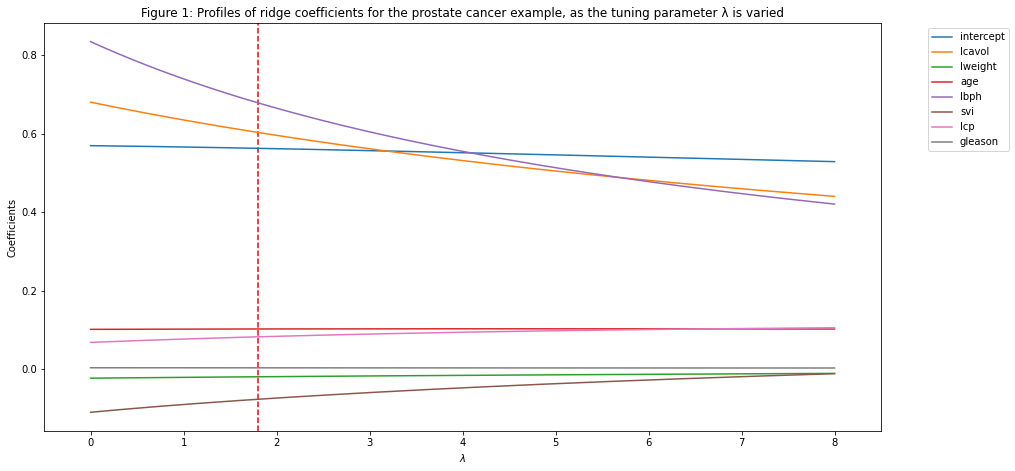

Best lambda found: 1.802


In [44]:
#initialize 
coeffs = np.zeros((Num_samples,p))

# coeff for each lambda
for i in range(len(lamrange)):
    coeffs[i,:] = weights[lamrange[i]]

# Plotting
plt.figure
plt.figure(figsize=(15,7.5)) 
for i in range(0,p):
  plt.plot(lamrange,coeffs[:,i])
  
plt.title('Figure 1: Profiles of ridge coefficients for the prostate cancer example, as the tuning parameter λ is varied')
plt.ylabel('Coefficients')
plt.xlabel('$\lambda$')
ymin, ymax = plt.ylim()
plt.legend(term, bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.xlim([-0.5,8.5])
plt.ylim([ymin,ymax])

#adding a line for the best lambda value
plt.vlines(opt_lambda_ridge, ymin, ymax, linestyle='dashed', colors='red')

plt.show()

#print the best lambda value
print('Best lambda found:', round(opt_lambda_ridge,3))


### Lasso Regression

In [45]:
# This time we don't need to implement the regression model, but get to use one 
# of the sklearn functions

alpharange = np.logspace(-6, 6, Num_samples)

opt_alpha_lasso, valMSE_lasso,weights_lasso = optimize_parameter(lm.Lasso,
                                                                 alpharange,
                                                                 X_train,
                                                                 y_train,
                                                                 X_val,
                                                                 y_val)
#generating a model using the optimal alpha
opt_lassomodel = lm.Lasso(alpha = opt_alpha_lasso)
opt_lassomodel.fit(X_train,y_train)

#Other MSEs
testMSE_lasso= mean_square_error(y_test, opt_lassomodel.predict(X_test))

#printing MSEs alnd alpha/lambda found
#print('Optimal alpha:' ,opt_alpha_lasso)
print('MSE from test data:', testMSE_lasso)

MSE from test data: 0.32141495098062234


#### Recreating Figure 3.10 (but with lambda rather than s)

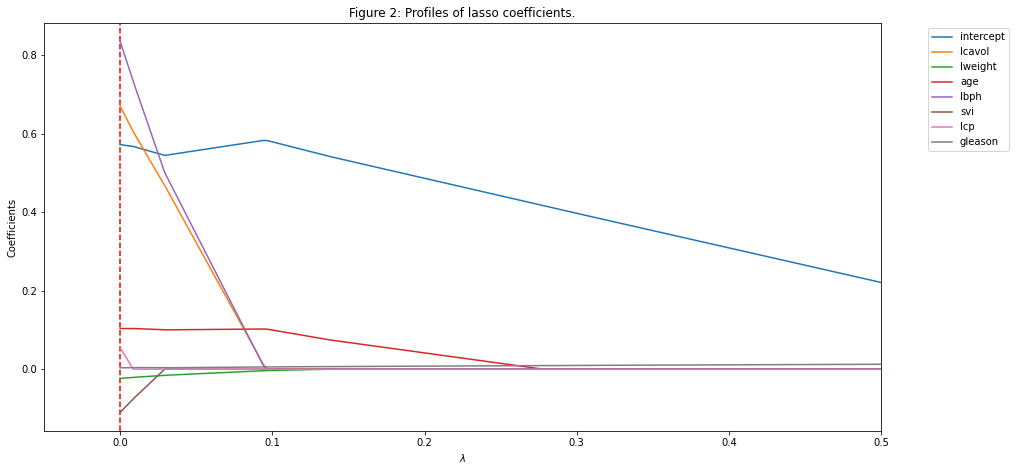

Best alpha found: 0.0


In [46]:
#initialize 
coeffs = np.zeros((Num_samples,p))

# coeff for each df
for i in range(len(alpharange)):
    coeffs[i,:] = weights_lasso[alpharange[i]]

# Plotting
plt.figure
plt.figure(figsize=(15,7.5)) 
for i in range(0,p):
  plt.plot(alpharange,coeffs[:,i])
  
plt.title('Figure 2: Profiles of lasso coefficients.')
plt.ylabel('Coefficients')
plt.xlabel('$\lambda$')
ymin, ymax = plt.ylim()
plt.legend(term, bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.xlim([-0.05,.5])
plt.ylim([ymin,ymax])


#adding a line for the best lambda value
plt.vlines(opt_alpha_lasso, ymin, ymax, linestyle='dashed', colors='red')

plt.show()

#print the best lambda value
print('Best alpha found:', round(opt_alpha_lasso,3))


###Prostate Cancer Model Summary

In [47]:
#Generating a summmary table

test_MSE = list([[testMSE_lin, testMSE_ridge, testMSE_lasso]])
table = tabulate(test_MSE, headers=['Linear Regression (MSE)', 'Ridge Regression (MSE)', 'Lasso Regression (MSE)'], tablefmt='orgtbl')

print(table)

|   Linear Regression (MSE) |   Ridge Regression (MSE) |   Lasso Regression (MSE) |
|---------------------------+--------------------------+--------------------------|
|                  0.321418 |                 0.290068 |                 0.321415 |


#Picked Dataset

## Importing the Real Estate Data 

In [48]:
!wget -O real_estate.xlsx http://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx

--2020-09-03 04:37:48--  http://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32717 (32K) [application/x-httpd-php]
Saving to: ‘real_estate.xlsx’

real_estate.xlsx    100%[===================>]  31.95K  --.-KB/s    in 0.04s   

2020-09-03 04:37:48 (913 KB/s) - ‘real_estate.xlsx’ saved [32717/32717]



In [49]:
real_estate = pd.read_excel('real_estate.xlsx', index_col=0)
re_data = real_estate.to_numpy().astype(np.float)

real_estate.head()


,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


##Splitting data into training, validation and testing

In [50]:
#Based on the problem chosen
#X = data[:,:-1] 
#y = data[:,-1]


split_data = train_val_test_split(re_data[:,:-1],
                                  re_data[:,-1],
                                  PERCENT_TEST,
                                  PERCENT_VAL,
                                  random_state)
#unpacking
X_train, X_val, X_test, y_train, y_val, y_test = split_data

print('Input length:', len(re_data))
print('Number of training samples:', len(X_train))
print('Number of validation samples:', len(X_val))
print('Number of testing samples:', len(X_test))


Input length: 414
Number of training samples: 331
Number of validation samples: 41
Number of testing samples: 42


##Data Overview

In [51]:
#Getting a prodile of the dataset
#real_estate_profile = ProfileReport(df_prostate, title="Pandas Profiling Report")
#real_estate_profile

##Models

### Linear Regression


In [55]:
linmodel = LinModel()
beta_lin = linmodel.fit(X_train,y_train)
testMSE_lin = mean_square_error(y_test, linmodel.predict(X_test))
print("Test MSE:", testMSE_lin)
#Calculate the correlation coefficients
corr_mat = np.corrcoef(X_train.T)
#formatting the correlation table 
coeff_names = list(real_estate.columns.values[:-1])
corr_table = format_corr_table(corr_mat, coeff_names)

#Fixing title
coeff_names.insert(0,'Coefficients')

#generate and pring correlation table
corr = tabulate(corr_table[1:], headers = (coeff_names), tablefmt='pretty')
print('\t\t\t     Table 3: Correlations of predictors in the real estate data.')
print(corr)

#the value of the variance approximation is VERY close to the MSE, but with a
# different dividing factor (MSE is N while here it is N-p-1)
p = len(coeff_names)-1

standard_error, Z_score = z_scorer(linmodel, X_train, y_train, p)

term = coeff_names[1:]
term.insert(0, 'intercept')
summary_mat = format_summary_table(term, beta_lin, standard_error, Z_score)

summary_header = ['Term', 'Coefficeint', 'Std. Error', 'Z Score']
summary = tabulate(summary_mat, headers = summary_header, tablefmt='pretty')
print('\t\tTable 2: Linear model fit to the real estate data.')
print(summary)

Test MSE: 179.31355694768695
			     Table 3: Correlations of predictors in the real estate data.
+----------------------------------------+---------------------+--------------+----------------------------------------+---------------------------------+-------------+
|              Coefficients              | X1 transaction date | X2 house age | X3 distance to the nearest MRT station | X4 number of convenience stores | X5 latitude |
+----------------------------------------+---------------------+--------------+----------------------------------------+---------------------------------+-------------+
|              X2 house age              |       -0.034        |              |                                        |                                 |             |
| X3 distance to the nearest MRT station |        0.042        |    -0.014    |                                        |                                 |             |
|    X4 number of convenience stores     |        0.049  

###Ridge Regression

MSE from test data: 180.52157151154992


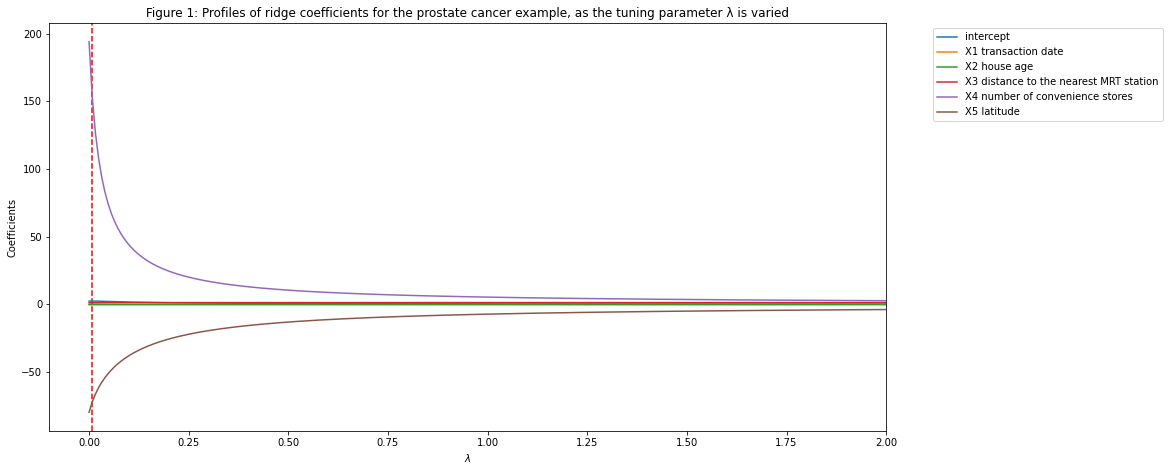

Best lambda found: 0.008


In [67]:
Num_samples = 1000
lamrange = np.linspace(0, 8, Num_samples)


opt_lambda_ridge, valMSE_ridge, weights = optimize_parameter(RidgeModel,
                                                             lamrange,
                                                             X_train,
                                                             y_train,
                                                             X_val,
                                                             y_val)

#creating a model using the optimal lambda
opt_ridgemodel = RidgeModel(opt_lambda_ridge)
opt_beta_ridge = opt_ridgemodel.fit(X_train, y_train)

#Test MSEs
testMSE_ridge= mean_square_error(y_test, opt_ridgemodel.predict(X_test))


#printing MSEs and lambda (latter to show we reached the min)
#print('Optimal Lambda:',opt_lambda_ridge)
#print('Optimal Ridge weights: ', opt_beta_ridge)
print('MSE from test data:',testMSE_ridge)

#initialize 
coeffs = np.zeros((Num_samples,p))

# coeff for each lambda
for i in range(len(lamrange)):
    coeffs[i,:] = weights[lamrange[i]]

# Plotting
plt.figure
plt.figure(figsize=(15,7.5)) 
for i in range(0,p):
  plt.plot(lamrange,coeffs[:,i])
  
plt.title('Figure 1: Profiles of ridge coefficients for the prostate cancer example, as the tuning parameter λ is varied')
plt.ylabel('Coefficients')
plt.xlabel('$\lambda$')
ymin, ymax = plt.ylim()
plt.legend(term, bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.xlim([-0.1,2])
plt.ylim([ymin,ymax])

#adding a line for the best lambda value
plt.vlines(opt_lambda_ridge, ymin, ymax, linestyle='dashed', colors='red')

plt.show()

#print the best lambda value
print('Best lambda found:', round(opt_lambda_ridge,3))


###Lasso Regression

MSE from test data: 179.98247202129815


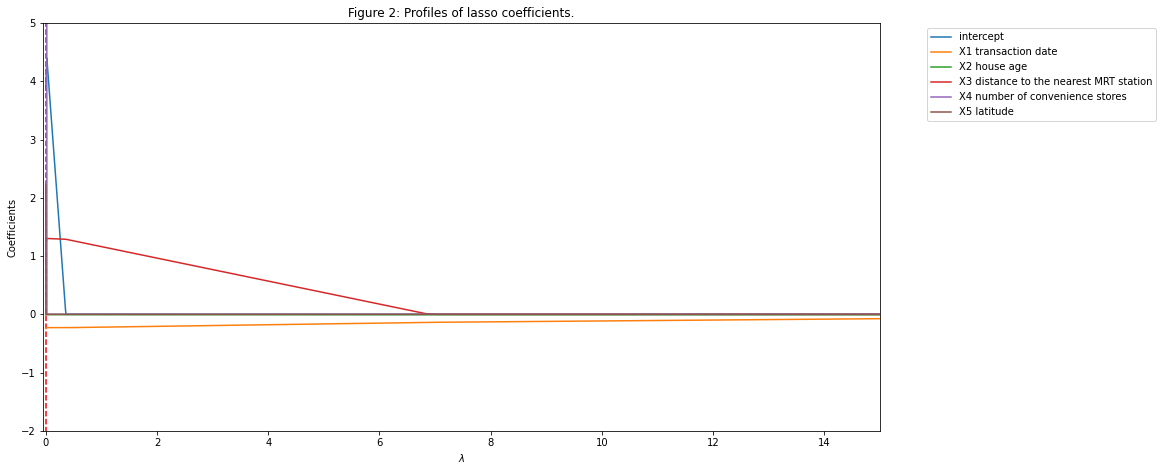

Best alpha found: 0.002


In [72]:
# This time we don't need to implement the regression model, but get to use one 
# of the sklearn functions

alpharange = np.logspace(-6, 6, Num_samples)

opt_alpha_lasso, valMSE_lasso,weights_lasso = optimize_parameter(lm.Lasso,
                                                                 alpharange,
                                                                 X_train,
                                                                 y_train,
                                                                 X_val,
                                                                 y_val)
#generating a model using the optimal alpha
opt_lassomodel = lm.Lasso(alpha = opt_alpha_lasso)
opt_lassomodel.fit(X_train,y_train)

#Other MSEs
testMSE_lasso= mean_square_error(y_test, opt_lassomodel.predict(X_test))

#printing MSEs alnd alpha/lambda found
#print('Optimal alpha:' ,opt_alpha_lasso)
print('MSE from test data:', testMSE_lasso)

#initialize 
coeffs = np.zeros((Num_samples,p))

# coeff for each df
for i in range(len(alpharange)):
    coeffs[i,:] = weights_lasso[alpharange[i]]

# Plotting
plt.figure
plt.figure(figsize=(15,7.5)) 
for i in range(0,p):
  plt.plot(alpharange,coeffs[:,i])
  
plt.title('Figure 2: Profiles of lasso coefficients.')
plt.ylabel('Coefficients')
plt.xlabel('$\lambda$')
ymin, ymax = plt.ylim()
plt.legend(term, bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.xlim([-0.05,15])
plt.ylim([-2,5])


#adding a line for the best lambda value
plt.vlines(opt_alpha_lasso, ymin, ymax, linestyle='dashed', colors='red')

plt.show()

#print the best lambda value
print('Best alpha found:', round(opt_alpha_lasso,3))


###Real Estate Model Summary

In [62]:
#Generating a summmary table

test_MSE = list([[testMSE_lin, testMSE_ridge, testMSE_lasso]])
table = tabulate(test_MSE, headers=['Linear Regression (MSE)', 'Ridge Regression (MSE)', 'Lasso Regression (MSE)'], tablefmt='orgtbl')

print(table)

|   Linear Regression (MSE) |   Ridge Regression (MSE) |   Lasso Regression (MSE) |
|---------------------------+--------------------------+--------------------------|
|                   179.314 |                  180.522 |                  179.982 |


# Overall Conclusions
Comparing the test MSE 